# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Цель проекта узнать рыночную стоимость автомобиля основываясь на данные

Задача с помощью разных моделей найти  оптимальную модель с лучшим временем обучения и предсказания.

Признаки

DateCrawled — дата скачивания анкеты из базы

VehicleType — тип автомобильного кузова

RegistrationYear — год регистрации автомобиля

Gearbox — тип коробки передач

Power — мощность (л. с.)

Model — модель автомобиля

Kilometer — пробег (км)

RegistrationMonth — месяц регистрации автомобиля

FuelType — тип топлива

Brand — марка автомобиля

Repaired — была машина в ремонте или нет

DateCreated — дата создания анкеты

NumberOfPictures — количество фотографий автомобиля

PostalCode — почтовый индекс владельца анкеты (пользователя)

LastSeen — дата последней активности пользователя

Целевой признак

Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import time
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/datasets/autos.csv')
dirty = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [5]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
column_names = ['Brand','Model','FuelType','RegistrationYear','Price','Gearbox','Power','Kilometer','Repaired','RegistrationMonth','VehicleType']
df = df.reindex(columns=column_names)

In [7]:
df['Repaired'] = df['Repaired'].map({'yes':1, 'no':0})

In [8]:
df['Repaired'] = df['Repaired'].fillna(0)

In [9]:
df['Repaired'] = df['Repaired'].astype('int64')

Убираем ненужные колонки

In [10]:
df['Repaired'].unique()

array([0, 1])

Меняем все Nan на unknown во все колонках

In [11]:
df

,Brand,Model,FuelType,RegistrationYear,Price,Gearbox,Power,Kilometer,Repaired,RegistrationMonth,VehicleType
0,volkswagen,golf,petrol,1993,480,manual,0,150000,0,0,NaN
1,audi,NaN,gasoline,2011,18300,manual,190,125000,1,5,coupe
2,jeep,grand,gasoline,2004,9800,auto,163,125000,0,8,suv
3,volkswagen,golf,petrol,2001,1500,manual,75,150000,0,6,small
4,skoda,fabia,gasoline,2008,3600,manual,69,90000,0,7,small
...,...,...,...,...,...,...,...,...,...,...,...
354364,mitsubishi,colt,petrol,2005,0,manual,0,150000,1,7,NaN
354365,sonstige_autos,NaN,NaN,2005,2200,NaN,0,20000,0,1,NaN
354366,smart,fortwo,petrol,2000,1199,auto,101,125000,0,3,convertible
354367,volkswagen,transporter,gasoline,1996,9200,manual,102,150000,0,3,bus


In [12]:
df['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [13]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [14]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [15]:
df['FuelType'] = df['FuelType'].fillna('unknown')

In [16]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [17]:
df = df[(df['RegistrationYear'] >= 1886) & (df['RegistrationYear'] <= 2016)]

In [18]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984,
       2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015,
       1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1970, 1965,
       1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961, 1960,
       1966, 1975, 1963, 1964, 1954, 1958, 1967, 1959, 1956, 1941, 1962,
       1929, 1957, 1940, 1949, 1937, 1951, 1953, 1933, 1950, 1948, 1952,
       1932, 1942, 1935, 1936, 1923, 1930, 1944, 1943, 1934, 1938, 1928,
       1919, 1931, 1915, 1920, 1947, 1927, 1946])

In [19]:
df

,Brand,Model,FuelType,RegistrationYear,Price,Gearbox,Power,Kilometer,Repaired,RegistrationMonth,VehicleType
0,volkswagen,golf,petrol,1993,480,manual,0,150000,0,0,NaN
1,audi,NaN,gasoline,2011,18300,manual,190,125000,1,5,coupe
2,jeep,grand,gasoline,2004,9800,auto,163,125000,0,8,suv
3,volkswagen,golf,petrol,2001,1500,manual,75,150000,0,6,small
4,skoda,fabia,gasoline,2008,3600,manual,69,90000,0,7,small
...,...,...,...,...,...,...,...,...,...,...,...
354364,mitsubishi,colt,petrol,2005,0,manual,0,150000,1,7,NaN
354365,sonstige_autos,NaN,unknown,2005,2200,NaN,0,20000,0,1,NaN
354366,smart,fortwo,petrol,2000,1199,auto,101,125000,0,3,convertible
354367,volkswagen,transporter,gasoline,1996,9200,manual,102,150000,0,3,bus


In [20]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [21]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')

In [22]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')

In [23]:
df['Model'] = df['Model'].fillna('unknown')

In [24]:
df['Power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,    60,   136,   160,   231,
         118,   193,    99,   113,   218,   122,   129,    70,   306,
          95,    61,   177,   170,    55,   143,   286,   232,   150,
         156,    80,    82,    90,   155,    54,   185,    87,   180,
          86,    84,   224,   235,   200,   178,   265,    77,   110,
         144,   120,   116,   184,   126,   204,    88,   194,    64,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    73,   192,    68,    66,   299,    74,
          52,   147,   310,    71,    97,    65,   239,   203,     5,
         300,   103,    85,   258,   320,    63,    81,   148,    44,
         145,   230,   280,   260,   104,   188,   333,   186,   117,
         141,   132,   234,   158,    39,    92,    51,   135,    59,
          53,   209,

In [25]:
df = df[(df['Power'] <= 1500)]

In [26]:
display(df.describe())

,RegistrationYear,Price,Power,Kilometer,Repaired,RegistrationMonth
count,339587.000000,339587.000000,339587.00000,339587.000000,339587.000000,339587.000000
mean,2002.482881,4472.004267,107.99108,128087.176482,0.102651,5.756222
std,7.091245,4546.405703,66.53755,37891.120423,0.303503,3.708124
min,1910.000000,0.000000,0.00000,5000.000000,0.000000,0.000000
25%,1999.000000,1099.000000,69.00000,125000.000000,0.000000,3.000000
50%,2003.000000,2799.000000,105.00000,150000.000000,0.000000,6.000000
75%,2007.000000,6500.000000,143.00000,150000.000000,0.000000,9.000000
max,2016.000000,20000.000000,1500.00000,150000.000000,1.000000,12.000000


In [27]:
df.duplicated().sum()

30119

In [28]:
df= df.drop_duplicates()

In [29]:
df.duplicated().sum()

0

In [30]:
df.dtypes

Brand                object
Model                object
FuelType             object
RegistrationYear      int64
Price                 int64
Gearbox              object
Power                 int64
Kilometer             int64
Repaired              int64
RegistrationMonth     int64
VehicleType          object
dtype: object

In [31]:
df.isna().sum()

Brand                0
Model                0
FuelType             0
RegistrationYear     0
Price                0
Gearbox              0
Power                0
Kilometer            0
Repaired             0
RegistrationMonth    0
VehicleType          0
dtype: int64

In [32]:
df

,Brand,Model,FuelType,RegistrationYear,Price,Gearbox,Power,Kilometer,Repaired,RegistrationMonth,VehicleType
0,volkswagen,golf,petrol,1993,480,manual,0,150000,0,0,unknown
1,audi,unknown,gasoline,2011,18300,manual,190,125000,1,5,coupe
2,jeep,grand,gasoline,2004,9800,auto,163,125000,0,8,suv
3,volkswagen,golf,petrol,2001,1500,manual,75,150000,0,6,small
4,skoda,fabia,gasoline,2008,3600,manual,69,90000,0,7,small
...,...,...,...,...,...,...,...,...,...,...,...
354364,mitsubishi,colt,petrol,2005,0,manual,0,150000,1,7,unknown
354365,sonstige_autos,unknown,unknown,2005,2200,unknown,0,20000,0,1,unknown
354366,smart,fortwo,petrol,2000,1199,auto,101,125000,0,3,convertible
354367,volkswagen,transporter,gasoline,1996,9200,manual,102,150000,0,3,bus


In [33]:
df['RegistrationYear'] = df['RegistrationYear'].astype('object')

<AxesSubplot:>

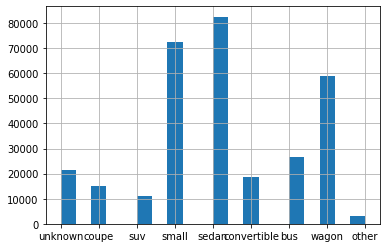

In [34]:
df['VehicleType'].hist(bins=20)

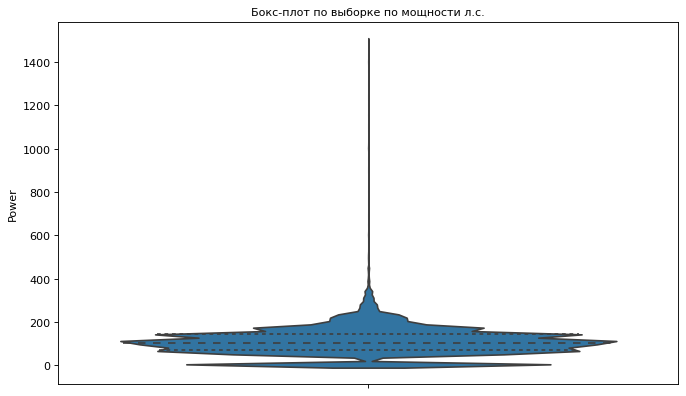

In [35]:
plt.figure(figsize=(10,6), dpi= 80)
sns.violinplot(y='Power', data=df, scale='width', inner='quartile', grid=True)

plt.title('Бокс-плот по выборке по мощности л.с.', fontsize=10)
plt.show()

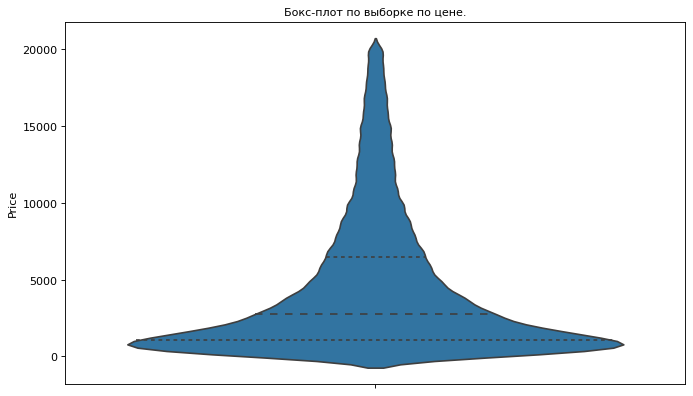

In [36]:
plt.figure(figsize=(10,6), dpi= 80)
sns.violinplot(y='Price', data=df, scale='width', inner='quartile', grid=True)

plt.title('Бокс-плот по выборке по цене.', fontsize=10)
plt.show()

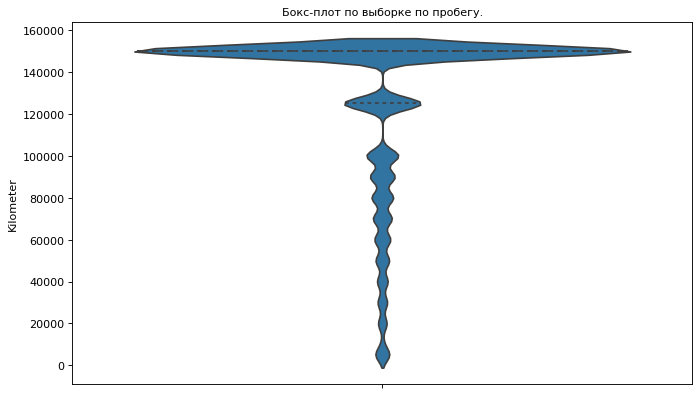

In [37]:
plt.figure(figsize=(10,6), dpi= 80)
sns.violinplot(y='Kilometer', data=df, scale='width', inner='quartile', grid=True)

plt.title('Бокс-плот по выборке по пробегу.', fontsize=10)
plt.show()

In [38]:
display(df.describe())

,Price,Power,Kilometer,Repaired,RegistrationMonth
count,309468.000000,309468.000000,309468.000000,309468.000000,309468.000000
mean,4465.457188,107.947513,127939.286130,0.107517,5.734800
std,4557.295368,66.804974,37995.571851,0.309770,3.706279
min,0.000000,0.000000,5000.000000,0.000000,0.000000
25%,1050.000000,69.000000,125000.000000,0.000000,3.000000
50%,2750.000000,105.000000,150000.000000,0.000000,6.000000
75%,6500.000000,143.000000,150000.000000,0.000000,9.000000
max,20000.000000,1500.000000,150000.000000,1.000000,12.000000


In [39]:
df = df.drop(df[df['Price'] == 0].index)

In [40]:
df = df.drop(df[df['Price'] == 1].index)

In [41]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299866 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Brand              299866 non-null  object
 1   Model              299866 non-null  object
 2   FuelType           299866 non-null  object
 3   RegistrationYear   299866 non-null  object
 4   Price              299866 non-null  int64 
 5   Gearbox            299866 non-null  object
 6   Power              299866 non-null  int64 
 7   Kilometer          299866 non-null  int64 
 8   Repaired           299866 non-null  int64 
 9   RegistrationMonth  299866 non-null  int64 
 10  VehicleType        299866 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.5+ MB


None

In [42]:
#df = df.drop(df[df['Power'] == 0].index)

In [43]:
df.shape[0] / dirty.shape[0]

0.8461970431950876

<AxesSubplot:>

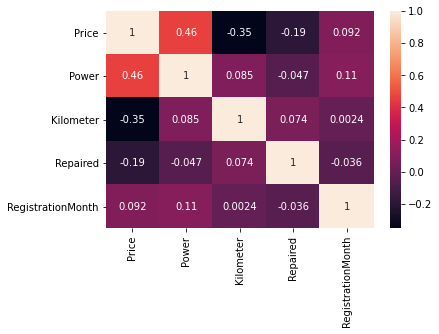

In [44]:
sns.heatmap (df.corr(), annot=True)

Наибольшая корелляция у цены с кол-вом л.с.

Вывод

Удалил дубликаты

Поменял столбцах тип данных

Избавился от ненужных столбцов

## Обучение моделей

In [45]:
target = df['Price']
features = df.drop('Price', axis=1)

In [46]:
features_train, features_inter, target_train, target_inter = train_test_split(
    features.copy(), 
    target.copy(), 
    test_size=0.4, 
    random_state=42)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_inter.copy(),
    target_inter.copy(),
    test_size=0.5,
    random_state=42)

In [47]:
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)

common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]

In [48]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['VehicleType','Gearbox','FuelType','Brand','Model']
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

In [49]:
cat_columns

['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Model']

```python
# прямое кодирование (для линейных моделей)
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
# после прямого кодирования кол-во признаков в выборках будет отличаться
# поэтому стоит удалить лишние признаки в каждой выборке

# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

# Оставим в каждой выборке только общие признаки
features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]
```

```python
# порядковое кодирование
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = [список всех категориальных признаков]
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])
```

In [50]:
features_train_ord = features_train_ord.reset_index(drop=True)
features_test_ord = features_test_ord.reset_index(drop=True)
features_valid_ord = features_valid_ord.reset_index(drop=True)

features_train_ohe = features_train_ohe.reset_index(drop=True)
features_test_ohe = features_test_ohe.reset_index(drop=True)
features_valid_ohe = features_valid_ohe.reset_index(drop=True)

In [51]:
def rmse(y, predictions):
    return mse(y, predictions) ** .5

rmse_score = make_scorer(rmse, greater_is_better=False)

In [52]:
%%time
state = 42
cv = KFold()
model = DecisionTreeRegressor(random_state=state)
    

param_dict = {'max_depth': range(1, 8),
              'min_samples_leaf' : range (1,6),
              'max_features' : range(1,7)}

griddtr = GridSearchCV(model, param_dict, cv = cv, scoring=rmse_score, n_jobs = -1)

griddtr.fit(features_train_ord, target_train)
griddtr.best_score_

CPU times: user 2min 57s, sys: 3.43 s, total: 3min
Wall time: 3min 1s


-2280.30574836527

In [53]:
print(griddtr.best_estimator_)
print()
print(griddtr.best_params_)
print()
print(griddtr.best_score_)

DecisionTreeRegressor(max_depth=7, max_features=6, min_samples_leaf=3,
                      random_state=42)

{'max_depth': 7, 'max_features': 6, 'min_samples_leaf': 3}

-2280.30574836527


In [54]:
scaler = StandardScaler()
X_train = scaler.fit_transform(features_train_ohe)
X_valid = scaler.transform(features_valid_ohe)
X_test = scaler.transform(features_test_ohe)

In [55]:
y_train = target_train
y_test = target_test
y_valid = target_valid

In [56]:
%%time
state = 42
cv = KFold()
model = LinearRegression()
    

param_dict = {'fit_intercept':[True, False],
                    'copy_X':[True, False]}

griddlr = GridSearchCV(model, param_dict, cv = cv, scoring=rmse_score, n_jobs = -1)
griddlr.fit(X_train, y_train)
griddlr.best_score_

CPU times: user 3min 25s, sys: 2min 35s, total: 6min
Wall time: 6min 1s


-2192.7601309918728

In [57]:
print(griddlr.best_estimator_)
print()
print(griddlr.best_params_)
print()
print(griddlr.best_score_)

LinearRegression()

{'copy_X': True, 'fit_intercept': True}

-2192.7601309918728


In [58]:
model = CatBoostRegressor() 
param_dict = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[42],
                'verbose':[False]}]

print()
gridcb = GridSearchCV(model, param_dict, scoring=rmse_score,n_jobs = -1)
gridcb.fit(features_train_ord, target_train)
gridcb.best_score_

-1639.8838142344703

In [59]:
%%time
print(gridcb.best_estimator_)
print()
print(gridcb.best_params_)
print()
print(gridcb.best_score_)


{'learning_rate': 0.1, 'random_state': 42, 'verbose': False}

-1639.8838142344703
CPU times: user 700 µs, sys: 158 µs, total: 858 µs
Wall time: 519 µs


In [60]:
model1 = DecisionTreeRegressor(random_state=42,
                               max_depth =7, 
                               max_features=6,
                               min_samples_leaf=3) 
start = time.time()
model1.fit(features_train_ord, target_train) 
fit_time = time.time() - start
predictions_1 = model1.predict(features_valid_ord)
pred_time = time.time() - start
result1 = rmse(target_valid,predictions_1)


print('DecisionTreeRegressor: ', result1)
print("Время обучения: ", fit_time)
print("Время предсказания: ", pred_time)

DecisionTreeRegressor:  2308.241725658256
Время обучения:  0.298691987991333
Время предсказания:  0.33732032775878906


In [61]:
model2 = LinearRegression(copy_X = True,
                          fit_intercept = True) 
start = time.time()
model2.fit(features_train_ord, target_train) 
fit_time = time.time() - start
predictions_2 = model2.predict(features_valid_ord)
pred_time = time.time() - start
result2 = rmse(target_valid,predictions_2)


print('LinearRegression: ', result2)
print("Время обучения: ", fit_time)
print("Время предсказания: ", pred_time)

LinearRegression:  3155.025666839666
Время обучения:  0.15411138534545898
Время предсказания:  0.2312319278717041


In [62]:
params = {
    'learning_rate': [0.1, 0.2],
    'n_estimators': [50, 100],
    'max_depth': [3, 4],
    'num_leaves': [10, 20],
}

model = LGBMRegressor(random_state=42)
grid_search = GridSearchCV(model, params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(features_train_ohe, target_train)

print('Best parameters:', grid_search.best_params_)
print('RMSE on validation set:', -grid_search.best_score_)

Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'num_leaves': 20}
RMSE on validation set: 1923.033089543174


## Тестирование лучшей модели

In [63]:
model_lgbm = LGBMRegressor(learning_rate=0.2,
n_estimators=100,
max_depth=4,
num_leaves=20)

model_lgbm.fit(features_train_ohe, target_train)

predictions_lgbm = model_lgbm.predict(features_test_ohe)

rmse_lgbm = mean_squared_error(target_test, predictions_lgbm)**0.5

print('RMSE на валидационной выборке для LGBMRegressor:', rmse_lgbm)

RMSE на валидационной выборке для LGBMRegressor: 1919.8293049229537


Итоговый вывод

Модели поделили на группы и для каждой закодировали признаки(ohe и ordinal)

После чего обучили модели и проверили сколько по времени обучается модели, сколько она предсказывает и с каким показателем rmse

самая точная LGBMRegressor

